In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [5]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    return df

13494


<AxesSubplot:xlabel='sector_human', ylabel='dist'>

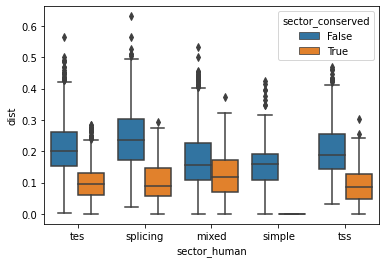

In [19]:
df = read_cons_table()
sns.boxplot(df, y='dist', x='sector_human', hue='sector_conserved')

## Alu element density

13494
             gene_id gene_name  gene_len  n_overlapping_alu   Gene stable ID  \
558  ENSG00000049540       ELN     42219                 30  ENSG00000049540   

    sector_human  sector_conserved  alus_per_kb  
558     splicing             False     0.710581  

Mean of human tes True sector conserved genes: 0.2685105423601638
Mean of human tes False sector conserved genes: 0.264525344859673

Mean of human simple True sector conserved genes: 0.21536969581757828
Mean of human simple False sector conserved genes: 0.22831833683488484

Mean of human mixed True sector conserved genes: 0.27399011633013937
Mean of human mixed False sector conserved genes: 0.26080590415712673

Mean of human splicing True sector conserved genes: 0.2550645744381698
Mean of human splicing False sector conserved genes: 0.30813327878367713

Mean of human tss True sector conserved genes: 0.19660019694026606
Mean of human tss False sector conserved genes: 0.24473708573445965

Median of human tes True sector cons

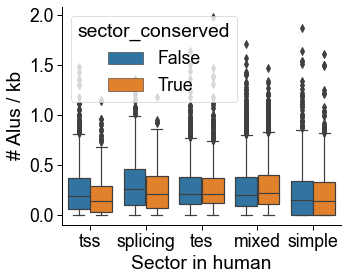

In [52]:
df = read_cons_table()

temp = pd.read_csv('alu_gtf_intersect.tsv', sep='\t')
temp['overlaps_alu'] = temp.Overlap==temp.alu_len
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)

# limit just to the orthologs
# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
temp2 = temp2.loc[temp2.gene_id.isin(all_gids)]
temp2 = temp2.merge(df[['Gene stable ID', 'sector_human', 'sector_conserved']],
                    how='left',
                    left_on='gene_id',
                    right_on='Gene stable ID')
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len
print(temp2.loc[temp2.gene_name=='ELN'])


sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(temp2, y='alus_per_kb', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel='# Alus / kb')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(temp2, 'alus_per_kb', test='mannwhitneyu')

In [8]:
def test_print_stat(df, test_col, test='mannwhitneyu'):
    # means of each dist and mann whitney u for each pair
    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Mean of human {s} {c} sector conserved genes: {temp[test_col].mean()}")


    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Median of human {s} {c} sector conserved genes: {temp[test_col].median()}")

    print()
    for s in df.sector_human.unique().tolist():  
        temp = df.loc[df.sector_human==s].copy(deep=True)
        a = temp.loc[temp.sector_conserved==True][test_col].tolist()
        b = temp.loc[temp.sector_conserved==False][test_col].tolist()
        if test=='mannwhitneyu':
            stat, pval = st.mannwhitneyu(a,b,alternative='two-sided')   
            print(f'Mann whitney u human {s} cons vs not cons: {stat}, p={pval}')
        elif test=='ttest_ind':
            stat, pval = st.ttest_ind(a,b,alternative='two-sided')
            print(f'Ttest ind human {s} cons vs not cons: {stat}, p={pval}')

## Intron size

13494


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Mean of human tes False sector conserved genes: 7250.466301798726
Mean of human tes True sector conserved genes: 10040.81797051454

Mean of human splicing False sector conserved genes: 5485.276220883671
Mean of human splicing True sector conserved genes: 4787.917031566732

Mean of human mixed False sector conserved genes: 4764.850949947532
Mean of human mixed True sector conserved genes: 6267.725890902153

Mean of human simple False sector conserved genes: 2088.5395976996524
Mean of human simple True sector conserved genes: 1452.5350987156344

Mean of human tss False sector conserved genes: 1558.5434307690682
Mean of human tss True sector conserved genes: 3671.307061814037

Median of human tes False sector conserved genes: 3046.2777777777783
Median of human tes True sector conserved genes: 5211.714285714286

Median of human splicing False sector conserved genes: 1964.1319444444453
Median of human splicing True sector conserved genes: 1135.9358974358977

Median of human mixed False sec

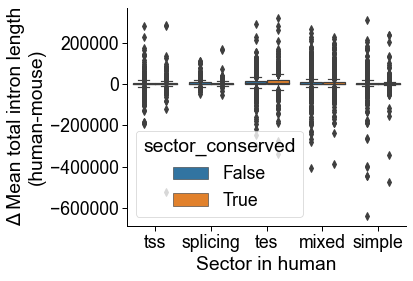

In [72]:
intron_df = pd.read_csv('human_intron_len.tsv', sep='\t')
m_intron_df = pd.read_csv('mouse_intron_len.tsv', sep='\t')

# set nans to 0s (genes w/ no introns)
intron_df.fillna(0, inplace=True)
m_intron_df.fillna(0, inplace=True)
# # get rid of nans (genes w/ no introns)
# intron_df = intron_df.loc[intron_df.mean_intron_len.notnull()]
# m_intron_df = m_intron_df.loc[m_intron_df.mean_intron_len.notnull()]

m_intron_df.rename({'mean_intron_len':'m_mean_intron_len',
                    'log_mean_intron_len':'m_log_mean_intron_len',
                    'gid':'Mouse gene stable ID'}, axis=1, inplace=True)
intron_df.rename({'gid':'Gene stable ID'}, axis=1, inplace=True)

df = read_cons_table()
df = df.merge(m_intron_df[['Mouse gene stable ID', 'm_mean_intron_len', 'm_log_mean_intron_len']],
              how='inner',
              on='Mouse gene stable ID')
df = df.merge(intron_df[['Gene stable ID', 'mean_intron_len', 'log_mean_intron_len']],
              how='inner',
              on='Gene stable ID')
df['mean_intron_len_dist'] = df['mean_intron_len']-df['m_mean_intron_len']
df['log_mean_intron_len_dist'] = np.log2(df.mean_intron_len_dist+0.1)
df.to_csv('mouse_human_intron_len.tsv', sep='\t')

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(df, y='mean_intron_len_dist', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel=u'Δ Mean total intron length\n(human-mouse)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(df, 'mean_intron_len_dist', test='ttest_ind')

## Intron size relative to gene length

In [7]:
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,dist,z_score,sector_conserved,splicing_conserved,mean_intron_len,log_mean_intron_len
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,Gnai3,NaN,NaN,protein_coding,0.250956,1.083932,False,False,42537.000000,15.376431
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,Cdc45,NaN,NaN,protein_coding,0.309879,1.728264,False,False,35081.105263,15.098407
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,Scml2,NaN,NaN,protein_coding,0.094295,-0.629199,True,False,58705.250000,15.841202
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,Narf,NaN,NaN,protein_coding,0.166471,0.160065,True,False,26608.589744,14.699604
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,Cav2,NaN,NaN,protein_coding,0.199584,0.522163,False,False,5408.307692,12.400962


## Conservation in splice flanking NTs

13494
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675
im here
1822386
754753
754753
181166
1462694
1461602
1461602
1461602
1461602
13494


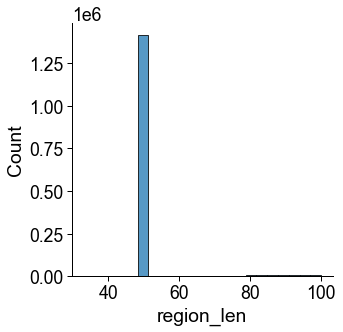

In [9]:
df = read_cons_table()

h_ca = cerberus.read(cerberus_h5)
h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
sj_df, sj_ic_df = get_sj_from_ic(h_ic, ['v29', 'v40'])

# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(sj_ic_df.index))
sj_ic_df = sj_ic_df.loc[sj_ic_df.Name.isin(temp['ic'].tolist())]
print(len(sj_ic_df.index))

sj_ic_df['iid'] = sj_ic_df.Chromosome+'_'+\
                 sj_ic_df.Strand+'_'+\
                 sj_ic_df.Start.astype(str)+'_'+\
                 sj_ic_df.End.astype(str)
sj_ic_df.head()
print(len(sj_ic_df.index))
print(len(sj_ic_df.iid.unique().tolist()))

# convert to PyRanges and get 50 nt upstream and downstream of each sj coordiate
extend = 50
len_min = extend*2
cols = ['Chromosome', 'Strand', 'Start', 'End', 'gene_id', 'Name']
h_df = sj_ic_df[cols].drop_duplicates()

n = len(h_df.index)
temp_h_df = h_df.loc[(h_df.End-h_df.Start)<len_min]
h_df = h_df.loc[~((h_df.End-h_df.Start)<len_min)]
assert len(temp_h_df.index)+len(h_df.index) == n

# introns >= 2*extension length
h_df['flank_5_End'] = h_df.Start+50
h_df['flank_3_Start'] = h_df.End-50
h_df.rename({'Start':'flank_5_Start',
             'End':'flank_3_End'},
            axis=1, inplace=True)
h_df['flank_5'] = h_df['flank_5_Start'].astype(str)+'_'+h_df['flank_5_End'].astype(str)
h_df['flank_3'] = h_df['flank_3_Start'].astype(str)+'_'+h_df['flank_3_End'].astype(str)
h_df.drop(['flank_5_Start', 'flank_5_End', 'flank_3_Start', 'flank_3_End'], axis=1, inplace=True)
h_df = h_df.melt(id_vars=['Chromosome', 'gene_id', 'Name', 'Strand'])
h_df[['Start', 'End']] = h_df.value.str.split('_', expand=True)
h_df['Start'] = h_df['Start'].astype(int)
h_df['End'] = h_df['End'].astype(int)

h_df.drop(['value', 'variable'], axis=1, inplace=True)
# print(h_df.loc[h_df.Name=='ENSG00000122435_1'])


# introns < 2*exension length just get the whole intron
h_df = pd.concat([h_df, temp_h_df], axis=0)

print(len(h_df.index))
h_df = pr.PyRanges(h_df)
h_df = h_df.merge(strand=True,
                  by=['gene_id', 'Name'],
                  count=True)
h_df = h_df.df
print(len(h_df.index))

h_df['region_len'] = h_df.End-h_df.Start
sns.displot(h_df, x='region_len')

h_df_back = h_df.copy(deep=True)
assert len(h_df.loc[(h_df.Count>1)&(h_df.region_len!=100)].index) == 0
h_df.drop('Count', axis=1, inplace=True)

# read phastcons stuff in and merge with human splice flank regions
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons['region_len'] = cons.End-cons.Start
cons['score_bp'] = cons.score/cons.region_len
cons = cons[['Chromosome', 'Start', 'End', 'score_bp']]
cons = pr.PyRanges(cons)

h_df = h_df_back
h_df['thing'] = h_df.Start.astype(str)+'_'+\
                     h_df.End.astype(str)+'_'+\
                     h_df.Name
print(len(h_df.thing.unique().tolist()))
h_df = pr.PyRanges(h_df)
h_df = h_df.join(cons, report_overlap=True, how='left')
h_df = h_df.df
print(len(h_df.thing.unique().tolist()))

# 0 out the things that do not have any overlap
h_df.loc[h_df.Start_b == -1, ['score', 'Overlap']] = 0
assert len(h_df.loc[(h_df.score == 0)&(h_df.Start_b!=-1)].index) == 0

gb_cols = ['Start', 'End', 'Name', 'region_len']
keep_cols = gb_cols+['region_score']
# h_df['region_score'] = h_df.score*h_df.Overlap
h_df['region_score'] = (h_df.Overlap*h_df.score_bp)/h_df.region_len

h_df.head()
# 1461602
temp = h_df[keep_cols].groupby(gb_cols).sum().reset_index()
temp.head()

print(len(temp.index))

# by ic
temp2 = temp[['Name', 'region_len', 'region_score']].groupby('Name').sum().reset_index()
temp2['score_per_bp'] = temp2['region_score']/temp2['region_len']
temp2.head()

# by gene
temp2['gid'] = temp2['Name'].str.split('_', expand=True)[0]
temp3 = temp2[['gid', 'score_per_bp']].groupby('gid').mean().reset_index().rename({'score_per_bp':'avg_score_per_bp_for_ics'}, axis=1)
temp3

temp3 = temp3.sort_values(by='avg_score_per_bp_for_ics', ascending=False)
temp3.head()

df = read_cons_table()
df = df[['gid_human', 'sector_mouse', 'sector_human']]
df.rename({'gid_human': 'gid'}, axis=1, inplace=True)
df = df.merge(temp3, on='gid', how='inner')
df['sector_conserved'] = df.sector_mouse == df.sector_human


Mean of human tes False sector conserved genes: 0.11462309259310698
Mean of human tes True sector conserved genes: 0.1204003386717746

Mean of human splicing False sector conserved genes: 0.10197963283803567
Mean of human splicing True sector conserved genes: 0.10168470133751444

Mean of human mixed False sector conserved genes: 0.10890590054569868
Mean of human mixed True sector conserved genes: 0.1086798130018978

Mean of human simple False sector conserved genes: 0.10686990194308221
Mean of human simple True sector conserved genes: 0.10528235270699919

Mean of human tss False sector conserved genes: 0.10398676232069023
Mean of human tss True sector conserved genes: 0.10906898769501586

Median of human tes False sector conserved genes: 0.11221677419403661
Median of human tes True sector conserved genes: 0.11920363036582607

Median of human splicing False sector conserved genes: 0.09903117249222829
Median of human splicing True sector conserved genes: 0.09530536674655413

Median of h

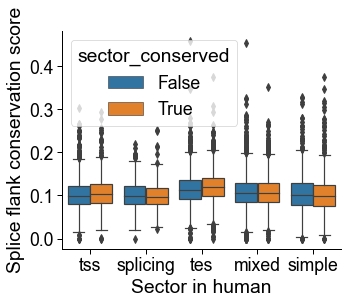

In [10]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(df, y='avg_score_per_bp_for_ics', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel='Splice flank conservation score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(df, 'avg_score_per_bp_for_ics', test='mannwhitneyu')

In [12]:
df.to_csv('splice_flank_conservation.tsv', sep='\t', index=False)

## Number of unique exons

In [96]:
df = read_cons_table()
h_ca = cerberus.read(cerberus_h5)
m_ca = cerberus.read(m_cerberus_h5)

h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
m_ic = m_ca.ic.loc[m_ca.ic.gene_id.isin(df.gid_mouse.tolist())]
print(len(h_ic.index))
print(len(m_ic.index))

e_df, e_ic_df = get_exon_from_ic(h_ic, ['v29', 'v40'])
m_e_df, m_e_ic_df = get_exon_from_ic(m_ic, ['vM21', 'vM25'])

# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(e_ic_df.index))
e_ic_df = e_ic_df.loc[e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(e_ic_df.index))

e_ic_df['eid'] = e_ic_df.Chromosome+'_'+\
                 e_ic_df.Strand+'_'+\
                 e_ic_df.Start.astype(str)+'_'+\
                 e_ic_df.End.astype(str)

# total unique, detected in mm samples exons / gene
h_temp = e_ic_df[['gene_id', 'eid']].groupby('gene_id').nunique().reset_index().rename({'eid':'n_unique_exons'}, axis=1)
h_temp.head()

m_ab = pd.read_csv(m_filt_ab, sep='\t')
_, tids = get_tpm_table(m_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col,
               species='mouse')
temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print(len(m_e_ic_df.index))
m_e_ic_df = m_e_ic_df.loc[m_e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(m_e_ic_df.index))

m_e_ic_df['eid'] = m_e_ic_df.Chromosome+'_'+\
                 m_e_ic_df.Strand+'_'+\
                 m_e_ic_df.Start.astype(str)+'_'+\
                 m_e_ic_df.End.astype(str)

# total unique, detected in mm samples exons / gene
m_temp = m_e_ic_df[['gene_id', 'eid']].groupby('gene_id').nunique().reset_index().rename({'eid':'n_unique_exons'}, axis=1)
m_temp.head()

temp = df[['gid_human', 'gid_mouse', 'sector_conserved']]
temp = temp.merge(m_temp, how='inner', left_on='gid_mouse', right_on='gene_id', suffixes=('', '_mouse'))
temp = temp.merge(h_temp, how='inner', left_on='gid_human', right_on='gene_id', suffixes=('', '_human'))
temp

df = read_cons_table()
temp = temp.merge(df[['gid_human', 'sector_human']],
                  how='left', 
                  on='gid_human')

13494
225037
106411
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675
im here
1599873
669801
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335
740775
538996
13494



Mean of human tes False sector conserved genes: 10.547110552763819
Mean of human tes True sector conserved genes: 11.352863726135615

Mean of human splicing False sector conserved genes: 12.330578512396695
Mean of human splicing True sector conserved genes: 13.780821917808218

Mean of human mixed False sector conserved genes: 11.579216977680204
Mean of human mixed True sector conserved genes: 12.342760180995475

Mean of human simple False sector conserved genes: 8.19119351100811
Mean of human simple True sector conserved genes: 6.610722610722611

Mean of human tss False sector conserved genes: 13.339622641509434
Mean of human tss True sector conserved genes: 13.801724137931034

Median of human tes False sector conserved genes: 8.0
Median of human tes True sector conserved genes: 9.0

Median of human splicing False sector conserved genes: 11.0
Median of human splicing True sector conserved genes: 12.0

Median of human mixed False sector conserved genes: 9.0
Median of human mixed True s

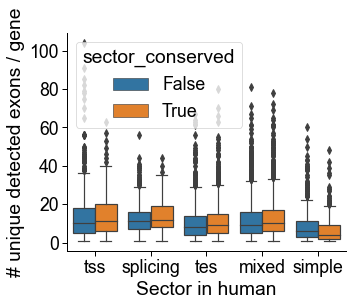

In [97]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(temp, y='n_unique_exons_human', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel='# unique detected exons / gene')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(temp, 'n_unique_exons_human', test='mannwhitneyu')

False
For genes w/ False sector conserved, pearson r=0.925377393615041 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.9229451164152352 and pval=0.0
True
For genes w/ True sector conserved, pearson r=0.9674109326172593 and pval=0.0
For genes w/ True sector conserved, spearman rho=0.9612335749648512 and pval=0.0
False
For genes w/ False sector conserved, pearson r=0.9100616489775628 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.8927262580010361 and pval=8.721821483437394e-295
True
For genes w/ True sector conserved, pearson r=0.8959782708716719 and pval=3.065710183821788e-104
For genes w/ True sector conserved, spearman rho=0.8856270870501869 and pval=1.3202658439140943e-98
True
For genes w/ True sector conserved, pearson r=0.9510153641205611 and pval=0.0
For genes w/ True sector conserved, spearman rho=0.9403908555027155 and pval=0.0
False
For genes w/ False sector conserved, pearson r=0.8920287529784909 and pval=0.0
For genes w/ False sector conserv

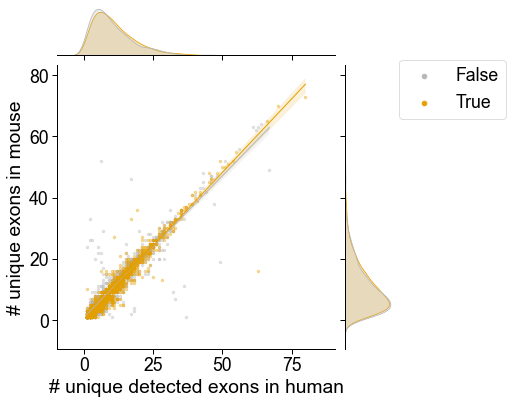

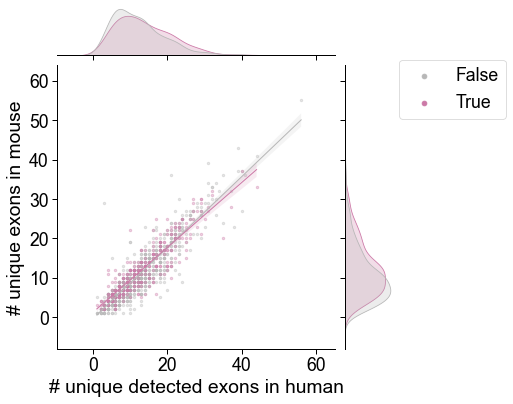

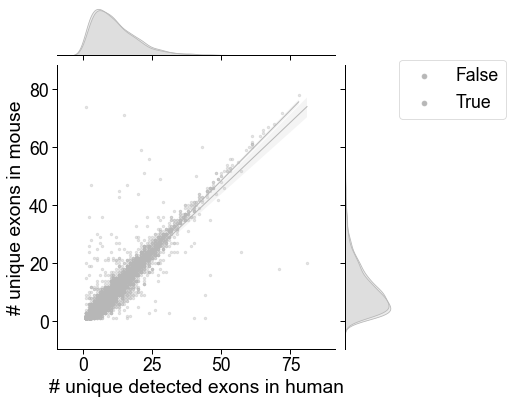

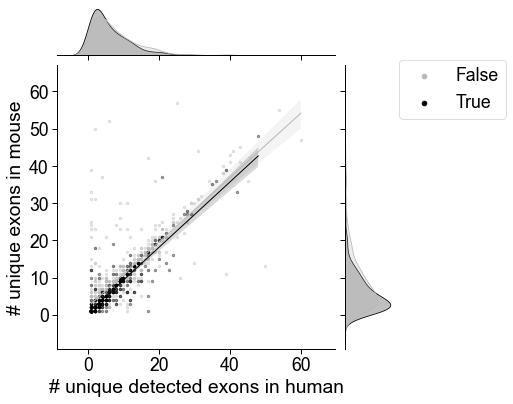

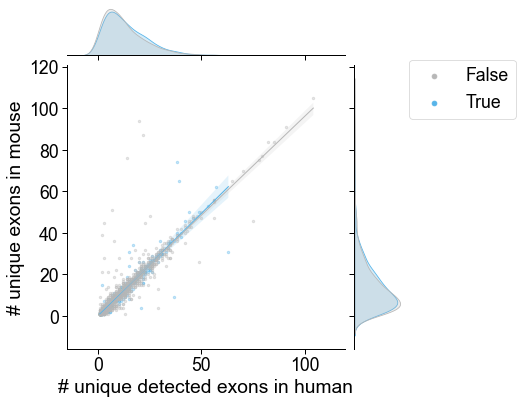

In [100]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
# fig, ax = plt.subplots(figsize=(6, 6))

for s in temp.sector_human.unique().tolist():
    temp3 = temp.loc[temp.sector_human==s].copy(deep=True)
    c_dict, order = get_sector_colors()
    # c_dict_2, order_2 = get_feat_triplet_colors(cats=None)
    new_c_dict = {True: c_dict[s],
                  False:  c_dict['mixed']}

    g = sns.jointplot(data=temp3, x='n_unique_exons_human', y='n_unique_exons',
                      hue='sector_conserved', palette=new_c_dict,
                      joint_kws={'s': 0},
                      marginal_kws={'common_norm': False})
    for i, v in enumerate(temp3.sector_conserved.unique()):
        print(v)
        temp2 = temp3.loc[temp3.sector_conserved==v]
        r, pval = stats.pearsonr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
        print(f'For genes w/ {v} sector conserved, pearson r={r} and pval={pval}')
        rho, pval = stats.spearmanr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
        print(f'For genes w/ {v} sector conserved, spearman rho={rho} and pval={pval}')

        sns.regplot(data=temp2, x='n_unique_exons_human',
                    y='n_unique_exons', ax=g.ax_joint, color=new_c_dict[v],
                    scatter_kws={'s': 6,
                                 'alpha': 0.35},
                    line_kws={'linewidth': 1})

    _ = g.ax_joint.set(xlabel='# unique detected exons in human', ylabel='# unique exons in mouse')
    legend = g.ax_joint.legend(title='Sector conserved')    
    g.ax_joint.legend(bbox_to_anchor=(1.2, 1.05))

## Max. number of exons

In [101]:
df = read_cons_table()
h_ca = cerberus.read(cerberus_h5)
m_ca = cerberus.read(m_cerberus_h5)

h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
m_ic = m_ca.ic.loc[m_ca.ic.gene_id.isin(df.gid_mouse.tolist())]
print(len(h_ic.index))
print(len(m_ic.index))

e_df, e_ic_df = get_exon_from_ic(h_ic, ['v29', 'v40'])
m_e_df, m_e_ic_df = get_exon_from_ic(m_ic, ['vM21', 'vM25'])

# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(e_ic_df.index))
e_ic_df = e_ic_df.loc[e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(e_ic_df.index))

e_ic_df['eid'] = e_ic_df.Chromosome+'_'+\
                 e_ic_df.Strand+'_'+\
                 e_ic_df.Start.astype(str)+'_'+\
                 e_ic_df.End.astype(str)

# max unique, detected in mm samples exons / ic / gene
h_temp = e_ic_df[['gene_id', 'eid', 'Name']].groupby(['gene_id', 'Name']).nunique().reset_index().rename({'eid':'n_exons'}, axis=1)
h_temp = h_temp[['gene_id', 'n_exons']].groupby('gene_id').max().reset_index().rename({'n_exons':'max_n_exons_per_ic'}, axis=1)

m_ab = pd.read_csv(m_filt_ab, sep='\t')
_, tids = get_tpm_table(m_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col,
               species='mouse')
temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print(len(m_e_ic_df.index))
m_e_ic_df = m_e_ic_df.loc[m_e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(m_e_ic_df.index))

m_e_ic_df['eid'] = m_e_ic_df.Chromosome+'_'+\
                 m_e_ic_df.Strand+'_'+\
                 m_e_ic_df.Start.astype(str)+'_'+\
                 m_e_ic_df.End.astype(str)


# max unique, detected in mm samples exons / ic / gene
m_temp = m_e_ic_df[['gene_id', 'eid', 'Name']].groupby(['gene_id', 'Name']).nunique().reset_index().rename({'eid':'n_exons'}, axis=1)
m_temp = m_temp[['gene_id', 'n_exons']].groupby('gene_id').max().reset_index().rename({'n_exons':'max_n_exons_per_ic'}, axis=1)


temp = df[['gid_human', 'gid_mouse', 'sector_conserved']]
temp = temp.merge(m_temp, how='inner', left_on='gid_mouse', right_on='gene_id', suffixes=('', '_mouse'))
temp = temp.merge(h_temp, how='inner', left_on='gid_human', right_on='gene_id', suffixes=('', '_human'))
temp

df = read_cons_table()
temp = temp.merge(df[['gid_human', 'sector_human']],
                  how='left', 
                  on='gid_human')

13494
225037
106411
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675
im here
1599873
669801
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335
740775
538996
13494



Mean of human tes False sector conserved genes: 9.704145728643216
Mean of human tes True sector conserved genes: 10.579986833443055

Mean of human splicing False sector conserved genes: 9.689492325855962
Mean of human splicing True sector conserved genes: 10.08904109589041

Mean of human mixed False sector conserved genes: 10.175997072813757
Mean of human mixed True sector conserved genes: 10.914781297134239

Mean of human simple False sector conserved genes: 7.595596755504055
Mean of human simple True sector conserved genes: 5.925407925407925

Mean of human tss False sector conserved genes: 12.155908639523336
Mean of human tss True sector conserved genes: 12.614942528735632

Median of human tes False sector conserved genes: 7.0
Median of human tes True sector conserved genes: 8.0

Median of human splicing False sector conserved genes: 8.0
Median of human splicing True sector conserved genes: 9.0

Median of human mixed False sector conserved genes: 8.0
Median of human mixed True secto

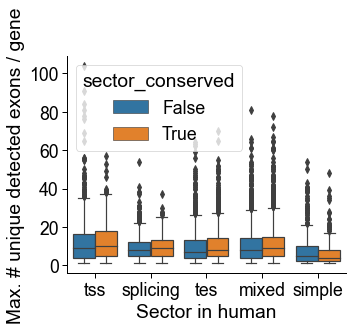

In [102]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.boxplot(temp, y='max_n_exons_per_ic_human', x='sector_human',
                 hue='sector_conserved', order=order)
ax.set(xlabel='Sector in human', ylabel='Max. # unique detected exons / gene')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

test_print_stat(temp, 'max_n_exons_per_ic_human', test='mannwhitneyu')

In [103]:
temp.head()

,gid_human,gid_mouse,sector_conserved,gene_id,max_n_exons_per_ic,gene_id_human,max_n_exons_per_ic_human,sector_human
0,ENSG00000065135,ENSMUSG00000000001,False,ENSMUSG00000000001,7,ENSG00000065135,7,tes
1,ENSG00000093009,ENSMUSG00000000028,False,ENSMUSG00000000028,18,ENSG00000093009,18,splicing
2,ENSG00000102098,ENSMUSG00000000037,True,ENSMUSG00000000037,24,ENSG00000102098,13,mixed
3,ENSG00000141562,ENSMUSG00000000056,True,ENSMUSG00000000056,9,ENSG00000141562,10,mixed
4,ENSG00000105971,ENSMUSG00000000058,False,ENSMUSG00000000058,1,ENSG00000105971,1,tes


False
For genes w/ False sector conserved, pearson r=0.9380609347476135 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.9501379104983528 and pval=0.0
True
For genes w/ True sector conserved, pearson r=0.9842089367041127 and pval=0.0
For genes w/ True sector conserved, spearman rho=0.9765244866364003 and pval=0.0
False
For genes w/ False sector conserved, pearson r=0.9755691272565657 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.9675519542175195 and pval=0.0
True
For genes w/ True sector conserved, pearson r=0.9936750184557454 and pval=1.8905127230635887e-277
For genes w/ True sector conserved, spearman rho=0.9896781589403877 and pval=9.84331764587421e-247
True
For genes w/ True sector conserved, pearson r=0.9685166589257304 and pval=0.0
For genes w/ True sector conserved, spearman rho=0.9738875006488206 and pval=0.0
False
For genes w/ False sector conserved, pearson r=0.9255795457110305 and pval=0.0
For genes w/ False sector conserved, spearman rho=0

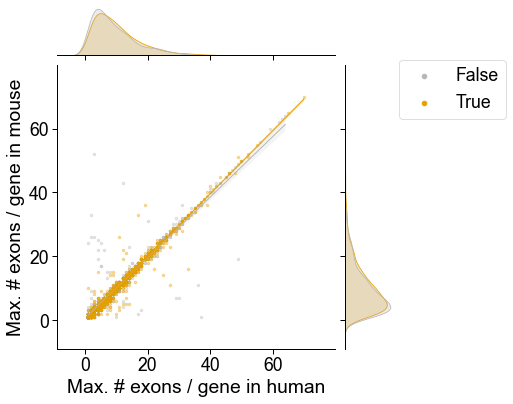

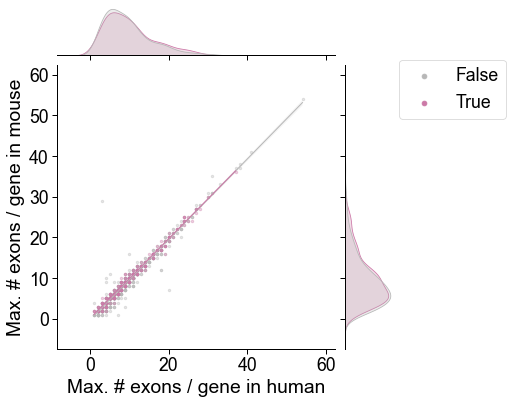

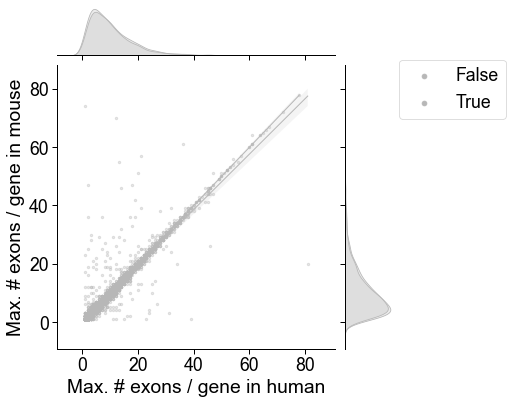

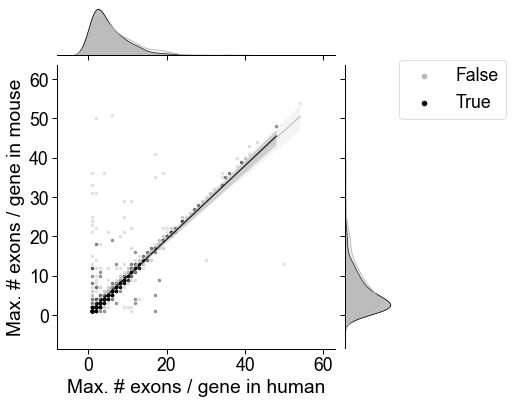

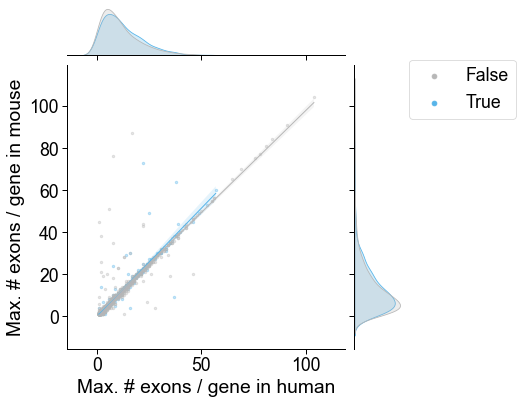

In [104]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
# fig, ax = plt.subplots(figsize=(6, 6))
x = 'max_n_exons_per_ic_human'
y = 'max_n_exons_per_ic'

for s in temp.sector_human.unique().tolist():
    temp3 = temp.loc[temp.sector_human==s].copy(deep=True)
    c_dict, order = get_sector_colors()
    # c_dict_2, order_2 = get_feat_triplet_colors(cats=None)
    new_c_dict = {True: c_dict[s],
                  False:  c_dict['mixed']}

    g = sns.jointplot(data=temp3, x=x, y=y,
                      hue='sector_conserved', palette=new_c_dict,
                      joint_kws={'s': 0},
                      marginal_kws={'common_norm': False})
    for i, v in enumerate(temp3.sector_conserved.unique()):
        print(v)
        temp2 = temp3.loc[temp3.sector_conserved==v]
        r, pval = stats.pearsonr(temp2[x].tolist(), temp2[y].tolist())

        print(f'For genes w/ {v} sector conserved, pearson r={r} and pval={pval}')
        rho, pval = stats.spearmanr(temp2[x].tolist(), temp2[y].tolist())
        print(f'For genes w/ {v} sector conserved, spearman rho={rho} and pval={pval}')

        sns.regplot(data=temp2, x=x,
                    y=y, ax=g.ax_joint, color=new_c_dict[v],
                    scatter_kws={'s': 6,
                                 'alpha': 0.35},
                    line_kws={'linewidth': 1})

    _ = g.ax_joint.set(xlabel='Max. # exons / gene in human', ylabel='Max. # exons / gene in mouse')
    legend = g.ax_joint.legend(title='Sector conserved')    
    g.ax_joint.legend(bbox_to_anchor=(1.2, 1.05))

## Sequence conservation of TSSs for genes that are TSS conserved vs. not TSS conserved

13494


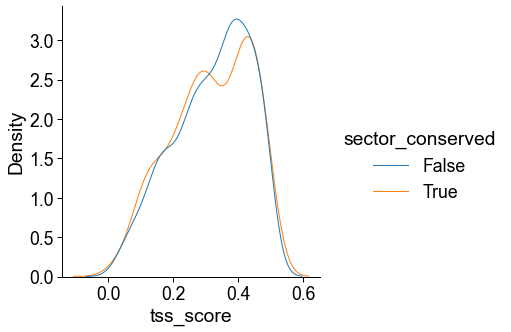

In [50]:
# how many tsss are conserved in human?
feat = 'tss'
end_df = pd.read_csv(f'human_{feat}_cons_score.tsv', sep='\t')
end_df = end_df[[f'{feat}_score', 'gene_id']]
cons = read_cons_table()

# only stuff that's feat-cons in human
cons = cons.loc[cons.sector_human=='tss']
cons = cons.merge(end_df, how='left', left_on='gid_human',
                  right_on='gene_id')

temp = cons.loc[cons[f'{feat}_score'] < 0.5]
ax = sns.displot(temp, x=f'{feat}_score',hue='sector_conserved', kind='kde', linewidth=1, common_norm=False)
# ax.set(xlim=(0,1))

13494


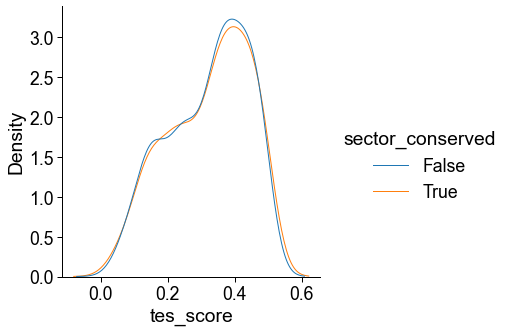

In [54]:
# how many tsss are conserved in human?
feat = 'tes'
end_df = pd.read_csv(f'human_{feat}_cons_score.tsv', sep='\t')
end_df = end_df[[f'{feat}_score', 'gene_id']]
cons = read_cons_table()

# only stuff that's feat-cons in human
cons = cons.loc[cons.sector_human=='tss']
cons = cons.merge(end_df, how='left', left_on='gid_human',
                  right_on='gene_id')

temp = cons.loc[cons[f'{feat}_score'] < 0.5]
ax = sns.displot(temp, x=f'{feat}_score',hue='sector_conserved', kind='kde', linewidth=1, common_norm=False)
# ax.set(xlim=(0,1))

In [39]:
cons = cons.merge(end_df, how='left', left_on='gid_human',
                  right_on='gene_id')
temp = cons.loc[cons[f'{feat}_score'] < 0.5]
ax = sns.displot(temp, x=f'{feat}_score',hue='sector_conserved', kind='kde', linewidth=1, common_norm=False)
# ax.set(xlim=(0,1))

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,dist,z_score,sector_conserved,splicing_conserved,tss_score,gene_id
0,ENSG00000169180,ENSMUSG00000000131,obs_mm_major,ENSG00000169180,9.0,1.0,10.0,13.0,2.0,0.75,...,Xpo6,NaN,NaN,protein_coding,0.214454,0.684775,True,False,1.876712,ENSG00000169180
1,ENSG00000169180,ENSMUSG00000000131,obs_mm_major,ENSG00000169180,9.0,1.0,10.0,13.0,2.0,0.75,...,Xpo6,NaN,NaN,protein_coding,0.214454,0.684775,True,False,2.856164,ENSG00000169180
2,ENSG00000169180,ENSMUSG00000000131,obs_mm_major,ENSG00000169180,9.0,1.0,10.0,13.0,2.0,0.75,...,Xpo6,NaN,NaN,protein_coding,0.214454,0.684775,True,False,1.597379,ENSG00000169180
3,ENSG00000169180,ENSMUSG00000000131,obs_mm_major,ENSG00000169180,9.0,1.0,10.0,13.0,2.0,0.75,...,Xpo6,NaN,NaN,protein_coding,0.214454,0.684775,True,False,4.500388,ENSG00000169180
4,ENSG00000169180,ENSMUSG00000000131,obs_mm_major,ENSG00000169180,9.0,1.0,10.0,13.0,2.0,0.75,...,Xpo6,NaN,NaN,protein_coding,0.214454,0.684775,True,False,1.465021,ENSG00000169180


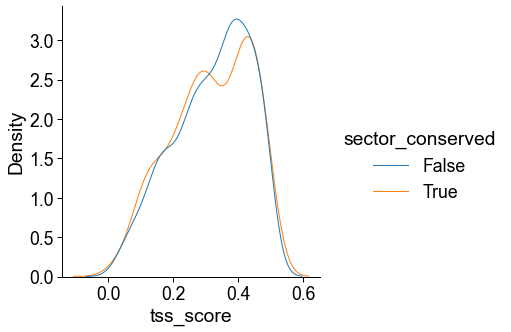

In [49]:
temp = cons.loc[cons[f'{feat}_score'] < 0.5]
ax = sns.displot(temp, x=f'{feat}_score',hue='sector_conserved', kind='kde', linewidth=1, common_norm=False)
# ax.set(xlim=(0,1))